## Import Packages

In [1]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd

import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
import skimage.future
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import rioxarray
from shapely.geometry import mapping
import networkx as nx
import matplotlib
import pandas as pd

#import cv2
import gcsfs
import json



<ipython-input-1-ab7a69326250>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
cd 

/home/jovyan


In [3]:
cd REMAWaterRouting/Functions/

/home/jovyan/REMAWaterRouting/Functions


In [4]:
cd  ..

/home/jovyan/REMAWaterRouting


In [5]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [6]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.7238535a9e494bfdbf5e3fce164f7ead, status=RUNNING>]

In [7]:
gateway.list_clusters()

[ClusterReport<name=prod.7238535a9e494bfdbf5e3fce164f7ead, status=RUNNING>]

In [8]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [9]:
client

<Client: 'tls://10.36.164.23:8786' processes=0 threads=0, memory=0 B>

In [10]:
cd REMAWaterRouting/

[Errno 2] No such file or directory: 'REMAWaterRouting/'
/home/jovyan/REMAWaterRouting


pip install dask_image

import dask_image.ndfilters


# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

In [11]:
cd 

/home/jovyan


In [12]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


<AxesSubplot:>

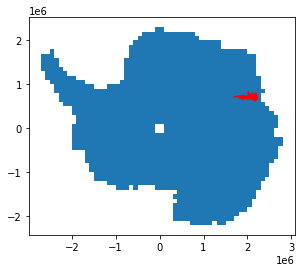

In [13]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf, the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']

#read in the REMA tile index
REMA_index = gpd.read_file('Functions/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Amery.geometry.plot(ax=axis,color='r')

In [14]:
#bounding box of ice shelf
[minx,miny,maxx,maxy]= Amery.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(col.min(),col.max()):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data

  0%|          | 0/2 [00:00<?, ?it/s]

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

### The following is a number of functions translated from Matlab's TopoToolbox to calculate drainage catchements from a DEM:

In [15]:
n=4
part = 1
filled=True
rem_x = np.remainder(ds_array.shape[0],n)
rem_y = np.remainder(ds_array.shape[1],n)
ds_array.data[ds_array.data<0]=np.nan
coarsed_masked_array = ds_array[rem_x:,rem_y:].coarsen(x=n,y=n).mean()

coarsed_masked_array.shape

(6250, 18750)

In [16]:
coarsed_masked_array

<xarray.DataArray (y: 6250, x: 18750)>
dask.array<mean_agg-aggregate, shape=(6250, 18750), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [17]:
cluster.scale(8)
cluster

In [18]:
coarsed_masked_array = coarsed_masked_array.chunk((3000,3000))

#if part==1:
#    sample  = coarsed_masked_array[:,0:int(coarsed_masked_array.shape[1]/3)]
#if part>1:
 #   sample  = coarsed_masked_array[:,(part-1)*int(coarsed_masked_array.shape[1]/3):part*int(coarsed_masked_array.shape[1]/3)]

sample = coarsed_masked_array
sample

<xarray.DataArray (y: 6250, x: 18750)>
dask.array<rechunk-merge, shape=(6250, 18750), dtype=float32, chunksize=(3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [19]:
cd 

/home/jovyan


In [20]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
#measures.to_zarr(mapper, mode='w');

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

atangent = dask.array.arctan(measures_dask.VX.data,measures_dask.VY.data)

measures_dask=measures_dask.assign(orientation =(['y','x'], atangent))

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [21]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
measures_resampled = measures_clipped.interp_like(sample)

chunks_y, chunks_x = sample.chunks
measures_resampled = measures_resampled.orientation.chunk({'x':chunks_x,'y':chunks_y})

In [22]:
measures_clipped

<xarray.Dataset>
Dimensions:       (x: 1334, y: 446)
Coordinates:
    lat           (y, x) float64 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(446, 1334), meta=np.ndarray>
  * x             (x) float64 1.6e+06 1.601e+06 1.601e+06 ... 2.2e+06 2.2e+06
  * y             (y) float64 8.002e+05 7.998e+05 7.993e+05 ... 6.004e+05 6e+05
    coord_system  int64 0
Data variables:
    CNT           (y, x) int32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    ERRX          (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    ERRY          (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    SOURCE        (y, x) int8 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    STDX          (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    STDY          (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    VX            (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    VY            (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
    orientation   (y, x) float32 dask.array<chunksize=(446, 1334), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    cdm_data_type:             Grid
    comment:                    
    creator_name:              J. Mouginot
    date_created:              2019-07-08T14:43:24.00005131959583Z
    geospatial_lat_max:        -60
    geospatial_lat_min:        -90
    geospatial_lat_units:      degrees_north
    geospatial_lon_max:        180
    geospatial_lon_min:        -180
    geospatial_lon_units:      degrees_east
    id:                        v_mix.v8Jul2019.nc
    institution:               Department of Earth System Science, University...
    keywords:                   
    keywords_vocabulary:        
    license:                   No restrictions on access or use.
    platform:                   
    product_version:            
    project:                   NASA/MEaSUREs
    sensor:                     
    spatial_resolution:        450 m
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    summary:                    
    time_coverage_end:         2016-12-31
    time_coverage_start:       1995-01-01
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    grid_mapping:              coord_system

In [23]:
# Export

# Part 3. Import and Calculate basin statistics


In [24]:
cd

/home/jovyan


In [25]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper('gs://ldeo-glaciology/REMA/processed/Amery')


processed = xr.open_zarr(mapper)  


processed.attrs.update({'crs':'+init=epsg:3031'})
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})



In [26]:
processed.DB_unfilled

<xarray.DataArray 'DB_unfilled' (y: 18750, x: 6250)>
dask.array<xarray-DB_unfilled, shape=(18750, 6250), dtype=float64, chunksize=(586, 391), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y        (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [27]:
processed =  processed.chunk({'x': 2000,'y':2000})
processed
cellsize = processed.res[1]

In [28]:
Filled = processed.transpose().P_all.data +sample.data

In [29]:
Filled = Filled.rechunk(2000).transpose()
Filled

dask.array<transpose, shape=(18750, 6250), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [30]:
mapper = gcs.get_mapper('gs://ldeo-glaciology/REMA/processed/Amery/accumulation')


accumulation = xr.open_zarr(mapper)  

In [31]:
accumulation

<xarray.Dataset>
Dimensions:              (x: 18750, y: 6250)
Dimensions without coordinates: x, y
Data variables:
    Accumulation_filled  (x, y) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>
    Streams_order        (x, y) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>

In [32]:
StreamOrder = accumulation.Streams_order.chunk({'x':2000,'y':2000})
Accumulation = accumulation.Accumulation_filled.chunk({'x':2000,'y':2000})
Accumulation

<xarray.DataArray 'Accumulation_filled' (x: 18750, y: 6250)>
dask.array<rechunk-merge, shape=(18750, 6250), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Dimensions without coordinates: x, y

In [33]:
cmap = matplotlib.colors.ListedColormap ( np.random.rand ( 256*3,3))


In [34]:
DB_label = processed.DB_unfilled.astype(int)

## Calculate the x,y coordinates of the chunks over which to calculate

In [35]:
chunks_x = np.int_((np.cumsum(DB_label.chunks[0])))
chunks_y = np.int_((np.cumsum(DB_label.chunks[1])))
chunks_x = chunks_x[chunks_x<DB_label.shape[0]]
chunks_y = chunks_y[chunks_y<DB_label.shape[1]]

chunks_x = np.concatenate(([0],chunks_x,[DB_label.shape[0]-1]))
chunks_y = np.concatenate(([0],chunks_y,[DB_label.shape[1]-1]))
chunks_x, chunks_y

(array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 18749]),
 array([   0, 2000, 4000, 6000, 6249]))

In [36]:
chunks={}
counter = 0
for j in np.arange(1,len(chunks_y)):
    for i in np.arange(1,len(chunks_x)):
        chunks[counter] = [chunks_x[i-1],chunks_x[i], chunks_y[j-1],chunks_y[j]]
        counter = counter+1

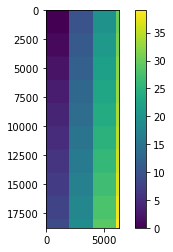

In [37]:
chunk_map = np.zeros(DB_label.shape)
for i in np.arange(0,len(chunks)):
    x1,x2,y1,y2 = chunks[i]
    chunk_map[x1:x2,y1:y2] = i

plt.imshow(chunk_map)
plt.colorbar()

In [38]:
cluster.scale(10)

## If not first time: Import csv of drainage catchment properties

In [39]:
import dask.dataframe
DB_merged_prop = pd.read_csv('Amery_DB_merged_prop.csv')

In [40]:
DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

In [41]:
#coords_str = DB_merged_prop['coords']

#coords_list = [coords.strip('[]').split(',') for coords in coords_str]

coords_formatted = {}
for index,coord in DB_merged_prop.coords.iteritems():
    
    coords_formatted[index] = np.int_([x.strip('[ ]') for x in DB_merged_prop['coords'][index].strip('[ ]').split(',')])
    

DB_merged_prop['coords_reformatted'] = coords_formatted.values()

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [42]:
#del coords_str
#del coords_list
del coords_formatted

In [43]:
DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)

## 1. Catchment Area, Volume, Coords, Max Depth

## Export to CSV

## Statistics Ordered by Lake Drainage Catchment

In [44]:
# Label lakes
islake = processed.P_all.chunk({'x':-1,'y':-1}).data>0

islake_filtered = ~dask.array.bitwise_not(islake).map_blocks(skimage.morphology.remove_small_holes, area_threshold=100)

islake_labelled_ = islake_filtered.map_blocks(skimage.measure.label,background=0)

islake_labelled = islake_labelled_.compute()

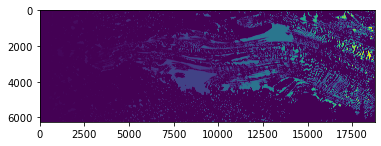

In [45]:
plt.imshow(islake_labelled.transpose())

In [46]:
def DB_regionprops2(DB,DB_filled):
    table_prop = skimage.measure.regionprops_table(DB,DB_filled,properties = ('label','max_intensity'))
    #pd_prop = pd.DataFrame(table_prop,index=table_prop['label'])
    #pd.concat([b,pd_prop])
    return table_prop

In [47]:
b_dict = {'label','large_lake_drainage'}
label=[0]
DB_prop2 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,P_all: DB_regionprops2(DB,P_all),DB_label.data[x1:x2,y1:y2],islake_labelled[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'large_lake_drainage': test_prop['max_intensity']},index=test_prop['label'])
    DB_prop2 = DB_prop2.append(pd_prop, ignore_index=True)

DB_prop2 = DB_prop2.groupby('label').agg({'large_lake_drainage':'max'}).reset_index()

In [48]:
DB_prop2 =  DB_prop2.sort_values('label').reset_index()

In [49]:
DB_merged_prop = DB_merged_prop.assign(large_lake_drainage = DB_prop2.large_lake_drainage)

In [50]:
large_lake_drainage_area = DB_merged_prop.groupby(DB_merged_prop.large_lake_drainage).Area_in_m.sum()
large_lake_drainage_area = large_lake_drainage_area.reset_index()


large_lake_drainage_volume = DB_merged_prop.groupby(DB_merged_prop.large_lake_drainage).catchment_volume.sum()

large_lake_drainage_volume = large_lake_drainage_volume.reset_index()

In [69]:
large_lake_drainage_area_coords = DB_merged_prop.groupby(DB_merged_prop.large_lake_drainage).coords_reformatted.aggregate([list]).reset_index()

In [70]:
import itertools

large_lake_drainage_area_coords_list = {}
for index, row in large_lake_drainage_area_coords.iterrows():
    large_lake_drainage_area_coords_list[index] = list(itertools.chain(*row.list))

In [71]:
large_lake_drainage_area_coords = pd.Series(large_lake_drainage_area_coords_list,name='coordinates')

In [72]:
Lake = large_lake_drainage_area.merge(large_lake_drainage_volume)

In [73]:
Lake = Lake.assign(ratio = lambda x: x['catchment_volume']/x['Area_in_m'])

(0.0, 10.0)

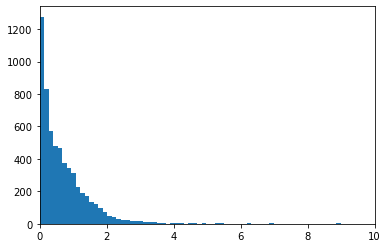

In [47]:
plt.hist(Lake.ratio[Lake.ratio>0],100)
plt.xlim([0,10])

ValueError: not enough values to unpack (expected 2, got 1)

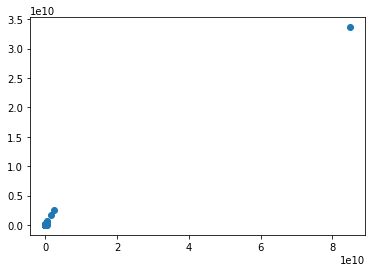

In [48]:
plt.scatter(Lake.Area_in_m.compute(), Lake.catchment_volume.values.compute())
plt.xlim([0,])

In [94]:
Lake.catchment_volume.idxmax().compute(),Lake.Area_in_m.idxmax().compute()

(0, 0)

In [56]:
# Large Lake Drainage Area Map:
output_map = np.zeros(DB_label.shape)
for index,row in Lake.iterrows():
    [x,y] = np.unravel_index(large_lake_drainage_area_coords.coordinates.iloc[index], DB_label.shape)
    output_map[x,y] = row.catchment_volume/row.Area_in_m
    


In [58]:
large_lake_drainage_areatovolume_xr = processed.P_all

large_lake_drainage_areatovolume_xr.data = output_map;
large_lake_drainage_areatovolume_xr.name = 'large_lake_drainage_area_to_volume'
large_lake_drainage_areatovolume_xr

In [59]:
large_lake_drainage_areatovolume_xr.to_netcdf('Amery_large_lake_drainage_area_to_volume.nc')

In [49]:
large_lake_drainage_areatovolume_xr = xr.open_dataarray('Amery_large_lake_drainage_area_to_volume.nc')

In [50]:
large_lake_drainage_areatovolume_xr

<xarray.DataArray 'large_lake_drainage_area_to_volume' (y: 18750, x: 6250)>
[117187500 values with dtype=float64]
Coordinates:
  * x        (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y        (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

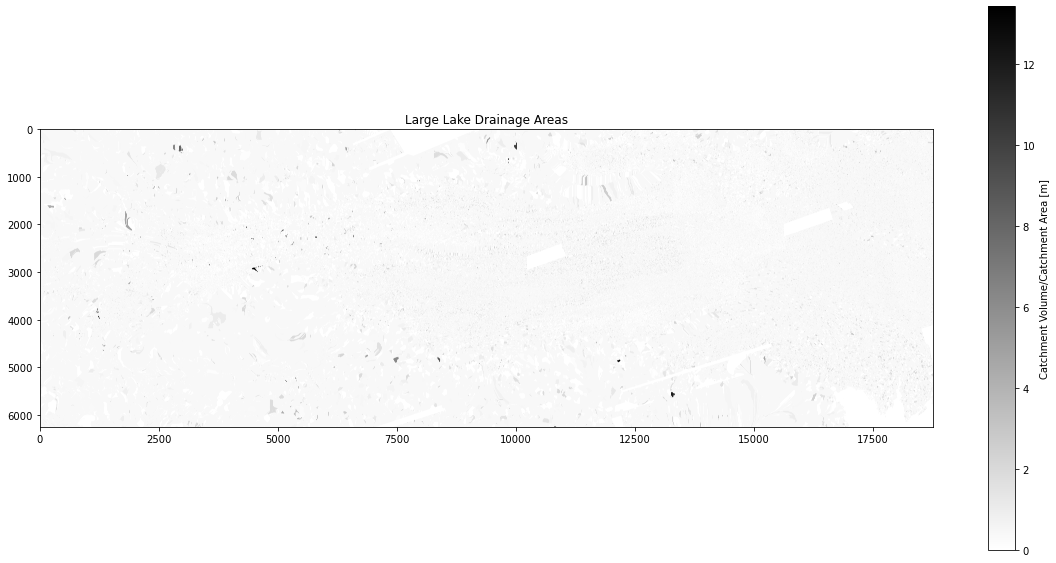

In [52]:
plt.figure(figsize=(20,10))
plt.imshow(large_lake_drainage_areatovolume_xr.data.transpose(),cmap='binary')
plt.title('Large Lake Drainage Areas')
h = plt.colorbar(label='Catchment Volume/Catchment Area [m]')


(0.0, 4.0)

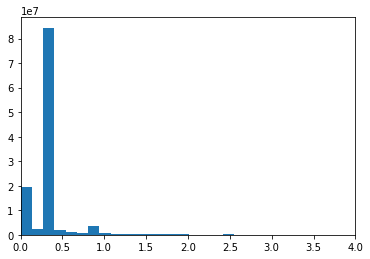

In [53]:
plt.hist(large_lake_drainage_areatovolume_xr.data.ravel(),100)
plt.xlim([0,4])

In [60]:
del Lake
del large_lake_drainage_area_coords
del large_lake_drainage_area_coords_list

## 3. Basin Catchment from Filled DEM

In [44]:
def DB_regionprops2(DB,DB_filled):
    table_prop = skimage.measure.regionprops_table(DB,DB_filled,properties = ('label','max_intensity'))
    #pd_prop = pd.DataFrame(table_prop,index=table_prop['label'])
    #pd.concat([b,pd_prop])
    return table_prop

In [45]:
DB_label.shape,processed.DB_filled.shape

((18750, 6250), (18750, 6250))

In [46]:
b_dict = {'label','filled_DB'}
label=[0]
DB_prop3 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,P_all: DB_regionprops2(DB,P_all),DB_label.data[x1:x2,y1:y2],processed.DB_filled.data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'filled_DB': test_prop['max_intensity']},index=test_prop['label'])
    DB_prop3 = DB_prop3.append(pd_prop, ignore_index=True)

In [47]:
DB_prop3 = DB_prop3.groupby('label').agg({'filled_DB':'first'}).reset_index()

In [48]:
DB_prop3 =  DB_prop3.sort_values('label').reset_index()

In [49]:
DB_merged_prop = DB_merged_prop.merge(DB_prop3)
DB_merged_prop

Dask DataFrame Structure:
                label   area eccentricity max_depth catchment_volume  coords Area_in_m volume_to_area_ratio coords_reformatted  index filled_DB
npartitions=10                                                                                                                                 
                int64  int64      float64     int64          float64  object   float64              float64             object  int64     int64
                  ...    ...          ...       ...              ...     ...       ...                  ...                ...    ...       ...
...               ...    ...          ...       ...              ...     ...       ...                  ...                ...    ...       ...
                  ...    ...          ...       ...              ...     ...       ...                  ...                ...    ...       ...
                  ...    ...          ...       ...              ...     ...       ...                  ...                ...    ...       ...
Dask Name: merge, 21 tasks

In [50]:
filled_DB_area = DB_merged_prop.groupby(DB_merged_prop.filled_DB).Area_in_m.sum()
#filled_DB_area = filled_DB_area.reset_index()

filled_DB_volume = DB_merged_prop.groupby(DB_merged_prop.filled_DB).catchment_volume.sum()

#filled_DB_volume = filled_DB_volume.reset_index()

In [115]:
filled_DB_stats = pd.Series(data={'area':filled_DB_area,'volume':filled_DB_volume})

In [116]:
filled_DB_stats

area      (41984.0, 21504.0, 27648.0, 14336.0, 1725440.0...
volume    (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [51]:
#sorted_index = np.argsort(filled_DB_stats.Area_in_m.compute())

In [53]:
import itertools
filled_DB_coords = DB_merged_prop.groupby(DB_merged_prop.filled_DB).coords_reformatted.aggregate([list])
filled_DB_coords_list = {}
for index, row in filled_DB_coords.iterrows():
    filled_DB_coords_list[index] = list(itertools.chain(*row.list))

In [54]:
filled_DB_coords = pd.Series(filled_DB_coords_list,name='coordinates')
del filled_DB_coords_list

In [55]:
filled_DB_coords

1       [108305505, 108305506, 108311755, 108311756, 1...
2       [117049529, 117055778, 117055779, 117062027, 1...
3       [117030701, 117036951, 117043198, 117043199, 1...
4       [117036961, 117036962, 117036963, 117036964, 1...
5       [116849379, 116849380, 116855627, 116855628, 1...
                              ...                        
8091    [57250074, 57256323, 57256324, 57256325, 57256...
8092    [13098293, 13104542, 13104543, 13110789, 13110...
8093                                 [57412549, 57412550]
8094    [13098289, 13098290, 13098291, 13098292, 13104...
8095    [13085790, 13085791, 13085792, 13092041, 13092...
Name: coordinates, Length: 8022, dtype: object

In [57]:
length = {}
for index,coords in filled_DB_coords.iteritems():
    length[index] = len(coords)

In [58]:
length = pd.Series(length)

In [63]:
length.idxmax()

4474

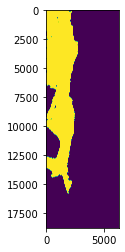

In [106]:
plt.imshow(processed.DB_filled.data==4474)
#plt.colorbar()

In [124]:
filled_DB_stats.ratio = filled_DB_stats.volume/filled_DB_stats.area

In [137]:
filled_DB_stats.ratio.index.max().compute()

8095

In [132]:
x,y = np.unravel_index(filled_DB_coords.iloc[1],DB_label.shape)

In [139]:
output_map = np.zeros(DB_label.shape)
for index,ratio in filled_DB_stats.ratio.iteritems():
    [x,y] = np.unravel_index(filled_DB_coords[index], DB_label.shape)
    output_map[x,y] = ratio
    

In [140]:
filled_DB_areatovolume_xr = processed.P_all

filled_DB_areatovolume_xr.data = output_map;
filled_DB_areatovolume_xr.name = 'filled_DB_volume_to_area'
filled_DB_areatovolume_xr

<xarray.DataArray 'filled_DB_volume_to_area' (y: 18750, x: 6250)>
array([[0.60096162, 0.60096162, 0.60096162, ..., 0.        , 0.        ,
        0.        ],
       [0.60096162, 0.60096162, 0.60096162, ..., 0.        , 0.        ,
        0.        ],
       [0.60096162, 0.60096162, 0.60096162, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * x        (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y        (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [141]:
filled_DB_areatovolume_xr.to_netcdf('Amery_filledDB_volume_to_area.nc')

In [142]:
filled_DB_areatovolume_xr = xr.open_dataarray('Amery_filledDB_volume_to_area.nc')

In [6]:
from matplotlib import pyplot as plt

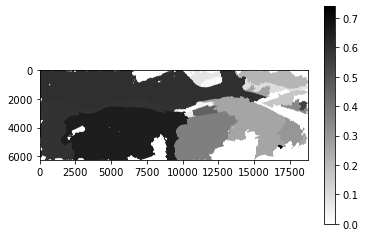

In [143]:
plt.imshow(filled_DB_areatovolume_xr.data.transpose(), cmap='binary')
plt.colorbar()

## 4. Ice Velocity from MEASUReS

In [146]:
def DB_regionprops3(DB,velocity):
    table_prop = skimage.measure.regionprops_table(DB,velocity,properties = ('label','mean_intensity'))
    #pd_prop = pd.DataFrame(table_prop,index=table_prop['label'])
    #pd.concat([b,pd_prop])?
    return table_prop

In [150]:
measures_resampled = measures_clipped.interp_like(sample)


In [151]:
velocity = dask.array.hypot(measures_resampled.VX, measures_resampled.VY).transpose().chunk(2000)
#measures_resampled = measures_resampled.assign(velocity =(['y','x'], velocity))

In [153]:
velocity.max().compute()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.DataArray 'VX' ()>
array(1186.80426027)
Coordinates:
    coord_system  int64 0

In [154]:
b_dict = {'label','mean_velocity'}
label=[0]
DB_prop3 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,velocity: DB_regionprops3(DB,velocity),DB_label.data[x1:x2,y1:y2],velocity.data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'mean_velocity': test_prop['mean_intensity']},index=test_prop['label'])
    DB_prop3 = DB_prop3.append(pd_prop, ignore_index=True)

In [155]:
DB_prop3 = DB_prop3.groupby('label').agg({'mean_velocity':'mean'}).reset_index()

In [156]:
DB_prop3 =  DB_prop3.sort_values('label').reset_index()

In [158]:
DB_merged_prop = DB_merged_prop.merge(DB_prop3)
DB_merged_prop


Unnamed: 0  label  area  eccentricity  max_depth  catchment_volume  \
0               0      1    41      0.791183          0          0.000000   
1               1      2   203      0.972609          0        413.951981   
2               2      3    21      0.822158          0          0.000000   
3               3      4    27      0.895215          0          0.000000   
4               4      5    14      0.895732          0          0.000000   
...           ...    ...   ...           ...        ...               ...   
52960       52960  52969    50      0.626331          0       1112.717088   
52961       52961  52970    27      0.776730          0        207.343075   
52962       52962  52971    30      0.898612          0         71.280923   
52963       52963  52972    15      0.859552          0         20.392980   
52964       52964  52973   125      0.990772          0         81.336596   

                                                  coords  Area_in_m  \
0      [[108305505, 108305506, 108311755, 108311756, ...    41984.0   
1      [[116849379, 116849380, 116855627, 116855628, ...   207872.0   
2      [[117049529, 117055778, 117055779, 117062027, ...    21504.0   
3      [[117030701, 117036951, 117043198, 117043199, ...    27648.0   
4      [[117036961, 117036962, 117036963, 117036964, ...    14336.0   
...                                                  ...        ...   
52960  [[96573134, 96579381, 96579382, 96579383, 9657...    51200.0   
52961  [[116622754, 116622755, 116622756, 116629003, ...    27648.0   
52962  [[116391095, 116391096, 116397344, 116397345, ...    30720.0   
52963  [[93123247, 93123248, 93129496, 93129497, 9312...    15360.0   
52964  [[110035155, 110035156, 110035157, 110041405, ...   128000.0   

       volume_to_area_ratio  index  large_lake_drainage  \
0                  0.000000      0                    0   
1                  0.001991      1                    0   
2                  0.000000      2                    0   
3                  0.000000      3                    0   
4                  0.000000      4                    0   
...                     ...    ...                  ...   
52960              0.021733  52960                    0   
52961              0.007499  52961                    0   
52962              0.002320  52962                    0   
52963              0.001328  52963                    0   
52964              0.000635  52964                    0   

                                      coords_reformatted  filled_DB  \
0      [108305505, 108305506, 108311755, 108311756, 1...          1   
1      [116849379, 116849380, 116855627, 116855628, 1...          5   
2      [117049529, 117055778, 117055779, 117062027, 1...          2   
3      [117030701, 117036951, 117043198, 117043199, 1...          3   
4      [117036961, 117036962, 117036963, 117036964, 1...          4   
...                                                  ...        ...   
52960  [96573134, 96579381, 96579382, 96579383, 96579...       2687   
52961  [116622754, 116622755, 116622756, 116629003, 1...       3222   
52962  [116391095, 116391096, 116397344, 116397345, 1...       3190   
52963  [93123247, 93123248, 93129496, 93129497, 93129...       3053   
52964  [110035155, 110035156, 110035157, 110041405, 1...        130   

       mean_velocity  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
52960     297.865813  
52961    1148.111339  
52962    1157.086135  
52963      22.645729  
52964     933.075505  

[52965 rows x 14 columns]

In [98]:
DB_merged_prop.to_csv('Amery_DB_merged_prop.csv')

In [ ]:
# Large Lake Drainage Area Map:
output_map = map_DB_statistic(DB_label,DB_prop_merged,'mean_velocity')
    

In [82]:
velocity_DB_xr = processed.P_all

In [83]:
velocity_DB_xr.data = output_map;
velocity_DB_xr.name = 'Mean_Velocity'
velocity_DB_xr

<xarray.DataArray 'Mean_Velocity' (y: 18750, x: 6250)>
array([[nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * x        (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y        (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06

In [84]:
velocity_DB_xr.to_netcdf('Amery_mean_velocity.nc')
#cluster.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [49]:
DB_label = DB_label.persist()

In [162]:
from intake import open_catalog


In [163]:
cat = open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/subshelf_meltrates/master/A2020_meltrates.yaml')
b  = cat["A2020_meltrates"].to_dask()
b = b.rio.write_crs('EPSG:3976')

In [164]:
b

<xarray.Dataset>
Dimensions:      (x: 10941, y: 10229)
Coordinates:
  * x            (x) float64 -2.736e+06 -2.736e+06 ... 2.734e+06 2.734e+06
  * y            (y) float64 -2.374e+06 -2.374e+06 ... 2.74e+06 2.74e+06
    spatial_ref  int64 0
Data variables:
    meltrates    (y, x) float64 dask.array<chunksize=(320, 684), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref

In [165]:
minx,miny,maxx,maxy

(1681977.9053338296, 609405.2873479566, 2246848.4903085832, 840132.5645477745)

In [166]:
b_clipped = b.rio.clip_box(minx,miny,maxx,maxy)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


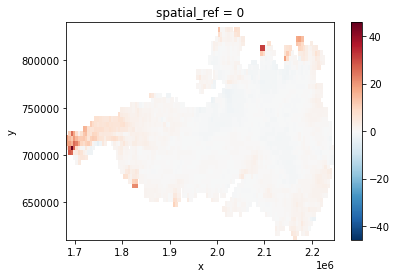

In [173]:
b_clipped.meltrates[2:,1:].coarsen(x=10,y=10).mean().plot()

In [174]:
b_resampled = b_clipped.interp_like(sample)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


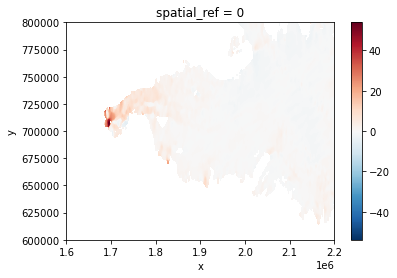

In [175]:
b_resampled.meltrates.coarsen(x=10,y=10).mean().plot()

In [176]:
b_dict = {'label','subshelfmelt'}
label=[0]
DB_prop4 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,b: DB_regionprops3(DB,b),DB_label.data[x1:x2,y1:y2],b_resampled.transpose().meltrates.data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'subshelfmelt': test_prop['mean_intensity']},index=test_prop['label'])
    DB_prop4 = DB_prop4.append(pd_prop, ignore_index=True)

In [177]:
DB_prop4 =  DB_prop4.sort_values('label').reset_index()
DB_prop4

index  subshelfmelt    label
0        1228267           NaN        1
1        1261019           NaN        2
2        1261020           NaN        3
3        1261021           NaN        4
4        1261022           NaN        5
...          ...           ...      ...
1284253    18537           NaN  1272477
1284254    18538           NaN  1272478
1284255    18539           NaN  1272479
1284256     6640           NaN  1272480
1284257        0           NaN      NaN

[1284258 rows x 3 columns]

In [183]:
DB_merged_prop['subshelfmelt'] = DB_prop4.subshelfmelt
DB_merged_prop

Unnamed: 0  label  area  eccentricity  max_depth  catchment_volume  \
0               0      1    41      0.791183          0          0.000000   
1               1      2   203      0.972609          0        413.951981   
2               2      3    21      0.822158          0          0.000000   
3               3      4    27      0.895215          0          0.000000   
4               4      5    14      0.895732          0          0.000000   
...           ...    ...   ...           ...        ...               ...   
52960       52960  52969    50      0.626331          0       1112.717088   
52961       52961  52970    27      0.776730          0        207.343075   
52962       52962  52971    30      0.898612          0         71.280923   
52963       52963  52972    15      0.859552          0         20.392980   
52964       52964  52973   125      0.990772          0         81.336596   

                                                  coords  Area_in_m  \
0      [[108305505, 108305506, 108311755, 108311756, ...    41984.0   
1      [[116849379, 116849380, 116855627, 116855628, ...   207872.0   
2      [[117049529, 117055778, 117055779, 117062027, ...    21504.0   
3      [[117030701, 117036951, 117043198, 117043199, ...    27648.0   
4      [[117036961, 117036962, 117036963, 117036964, ...    14336.0   
...                                                  ...        ...   
52960  [[96573134, 96579381, 96579382, 96579383, 9657...    51200.0   
52961  [[116622754, 116622755, 116622756, 116629003, ...    27648.0   
52962  [[116391095, 116391096, 116397344, 116397345, ...    30720.0   
52963  [[93123247, 93123248, 93129496, 93129497, 9312...    15360.0   
52964  [[110035155, 110035156, 110035157, 110041405, ...   128000.0   

       volume_to_area_ratio  index  large_lake_drainage  \
0                  0.000000      0                    0   
1                  0.001991      1                    0   
2                  0.000000      2                    0   
3                  0.000000      3                    0   
4                  0.000000      4                    0   
...                     ...    ...                  ...   
52960              0.021733  52960                    0   
52961              0.007499  52961                    0   
52962              0.002320  52962                    0   
52963              0.001328  52963                    0   
52964              0.000635  52964                    0   

                                      coords_reformatted  filled_DB  \
0      [108305505, 108305506, 108311755, 108311756, 1...          1   
1      [116849379, 116849380, 116855627, 116855628, 1...          5   
2      [117049529, 117055778, 117055779, 117062027, 1...          2   
3      [117030701, 117036951, 117043198, 117043199, 1...          3   
4      [117036961, 117036962, 117036963, 117036964, 1...          4   
...                                                  ...        ...   
52960  [96573134, 96579381, 96579382, 96579383, 96579...       2687   
52961  [116622754, 116622755, 116622756, 116629003, 1...       3222   
52962  [116391095, 116391096, 116397344, 116397345, 1...       3190   
52963  [93123247, 93123248, 93129496, 93129497, 93129...       3053   
52964  [110035155, 110035156, 110035157, 110041405, 1...        130   

       mean_velocity  subshelfmelt  
0                NaN           NaN  
1                NaN           NaN  
2                NaN           NaN  
3                NaN           NaN  
4                NaN           NaN  
...              ...           ...  
52960     297.865813      1.109315  
52961    1148.111339      0.699734  
52962    1157.086135      1.238098  
52963      22.645729      0.386794  
52964     933.075505     -1.408986  

[52965 rows x 15 columns]

In [184]:
DB_merged_prop.to_csv('Amery_DB_merged_prop.csv')

In [185]:
vulnerability = xr.open_dataarray('lai_vulnerability_georefed.nc')

In [186]:
vulnerability

<xarray.DataArray (x: 5501, y: 5501)>
[30261001 values with dtype=float64]
Coordinates:
  * x        (x) float64 2.75e+06 2.749e+06 2.748e+06 ... -2.749e+06 -2.75e+06
  * y        (y) float64 -2.75e+06 -2.749e+06 -2.748e+06 ... 2.749e+06 2.75e+06

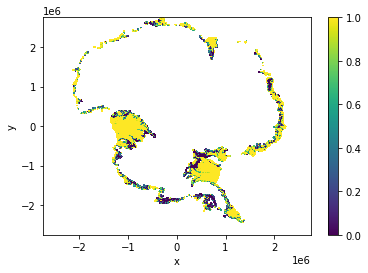

In [187]:
vulnerability[:-1,:-1].transpose().coarsen(x=10,y=10).mean().plot()

In [188]:
vulnerability.attrs.update({'crs':'+init=epsg:3031'})
vulnerability.attrs.update({'res': (1000.0, 1000.0)})
vulnerability.attrs.update({'is_tiled': 1})
vulnerability.attrs.update({'nodatavals': (np.nan,)})
vulnerability.attrs.update({'scales': (1.0,)})
vulnerability.attrs.update({'offsets': (0.0,)})


In [189]:
vulnerability = vulnerability.rio.write_crs('EPSG:3031')


In [204]:
vulnerability = vulnerability.rio.write_crs('EPSG:3031')

vulnerability.rio.crs

[minx,miny,maxx,maxy] = sample.rio.bounds()

vulnerability_clipped = vulnerability.transpose().rio.clip_box(miny,minx,maxy,maxx)
vulnerability_resampled = vulnerability_clipped.interp(x = processed.x.data, y=processed.y.data, method='nearest').T

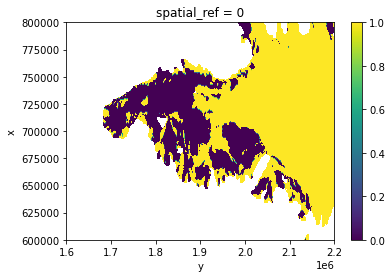

In [205]:
vulnerability_resampled.coarsen(x=10,y=10).mean().plot()

In [207]:
b_dict = {'label','vulnerability'}
label=[0]
DB_prop5 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,b: DB_regionprops3(DB,b),DB_label.data[x1:x2,y1:y2],vulnerability_resampled.transpose().data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'vulnerability': test_prop['mean_intensity']},index=test_prop['label'])
    DB_prop5 = DB_prop5.append(pd_prop, ignore_index=True)

In [208]:
DB_prop5 =  DB_prop5.sort_values('label').reset_index()


In [209]:
DB_merged_prop['vulnerability'] = DB_prop5.vulnerability

In [211]:
DB_merged_prop

Unnamed: 0  label  area  eccentricity  max_depth  catchment_volume  \
0               0      1    41      0.791183          0          0.000000   
1               1      2   203      0.972609          0        413.951981   
2               2      3    21      0.822158          0          0.000000   
3               3      4    27      0.895215          0          0.000000   
4               4      5    14      0.895732          0          0.000000   
...           ...    ...   ...           ...        ...               ...   
52960       52960  52969    50      0.626331          0       1112.717088   
52961       52961  52970    27      0.776730          0        207.343075   
52962       52962  52971    30      0.898612          0         71.280923   
52963       52963  52972    15      0.859552          0         20.392980   
52964       52964  52973   125      0.990772          0         81.336596   

                                                  coords  Area_in_m  \
0      [[108305505, 108305506, 108311755, 108311756, ...    41984.0   
1      [[116849379, 116849380, 116855627, 116855628, ...   207872.0   
2      [[117049529, 117055778, 117055779, 117062027, ...    21504.0   
3      [[117030701, 117036951, 117043198, 117043199, ...    27648.0   
4      [[117036961, 117036962, 117036963, 117036964, ...    14336.0   
...                                                  ...        ...   
52960  [[96573134, 96579381, 96579382, 96579383, 9657...    51200.0   
52961  [[116622754, 116622755, 116622756, 116629003, ...    27648.0   
52962  [[116391095, 116391096, 116397344, 116397345, ...    30720.0   
52963  [[93123247, 93123248, 93129496, 93129497, 9312...    15360.0   
52964  [[110035155, 110035156, 110035157, 110041405, ...   128000.0   

       volume_to_area_ratio  index  large_lake_drainage  \
0                  0.000000      0                    0   
1                  0.001991      1                    0   
2                  0.000000      2                    0   
3                  0.000000      3                    0   
4                  0.000000      4                    0   
...                     ...    ...                  ...   
52960              0.021733  52960                    0   
52961              0.007499  52961                    0   
52962              0.002320  52962                    0   
52963              0.001328  52963                    0   
52964              0.000635  52964                    0   

                                      coords_reformatted  filled_DB  \
0      [108305505, 108305506, 108311755, 108311756, 1...          1   
1      [116849379, 116849380, 116855627, 116855628, 1...          5   
2      [117049529, 117055778, 117055779, 117062027, 1...          2   
3      [117030701, 117036951, 117043198, 117043199, 1...          3   
4      [117036961, 117036962, 117036963, 117036964, 1...          4   
...                                                  ...        ...   
52960  [96573134, 96579381, 96579382, 96579383, 96579...       2687   
52961  [116622754, 116622755, 116622756, 116629003, 1...       3222   
52962  [116391095, 116391096, 116397344, 116397345, 1...       3190   
52963  [93123247, 93123248, 93129496, 93129497, 93129...       3053   
52964  [110035155, 110035156, 110035157, 110041405, 1...        130   

       mean_velocity  subshelfmelt  vulnerability  
0                NaN           NaN            1.0  
1                NaN           NaN            NaN  
2                NaN           NaN            NaN  
3                NaN           NaN            NaN  
4                NaN           NaN            NaN  
...              ...           ...            ...  
52960     297.865813      1.109315            1.0  
52961    1148.111339      0.699734            1.0  
52962    1157.086135      1.238098            1.0  
52963      22.645729      0.386794            1.0  
52964     933.075505     -1.408986            1.0  

[52965 rows x 16 columns]

In [93]:
DB_merged_prop.to_csv('DB_merged_prop.csv')

In [94]:
DB_merged_prop

Empty DataFrame
Columns: [label, area, eccentricity, max_depth, catchment_volume, coords, Area_in_m, volume_to_area_ratio, level_0, index, large_lake_drainage, filled_DB, accumulation]
Index: []

In [52]:
DB_prop_merged = pd.read_csv('Amery_32m_DBproperties.csv')


In [204]:
Filled = dask.array.add(processed.P_all, sample.transpose())

In [205]:
Filled = Filled.persist()
Filled

<xarray.DataArray 'P_all' (y: 0, x: 0)>
dask.array<add, shape=(0, 0), dtype=float64, chunksize=(0, 0), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 
  * x        (x) float64 
    band     int64 1

In [44]:
def DB_regionprops4(DB,DEM):
    table_prop = skimage.measure.regionprops_table(DB,DEM,properties = ('label','mean_intensity', 'max_intensity','min_intensity'))
    #pd_prop = pd.DataFrame(table_prop,index=table_prop['label'])
    #pd.concat([b,pd_prop])?
    return table_prop

In [49]:
b_dict = {'label','mean_elevation','max_elevation','min_elevation'}
label=[0]
DB_prop6 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,DEM: DB_regionprops4(DB,DEM),DB_label.data[x1:x2,y1:y2],sample.chunk(2000).data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'mean_elevation': test_prop['mean_intensity'],'max_elevation': test_prop['max_intensity'],'min_elevation': test_prop['min_intensity']},index=test_prop['label'])
    DB_prop6 = DB_prop6.append(pd_prop, ignore_index=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.

In [50]:
DB_prop6 =  DB_prop6.sort_values('label').reset_index()


In [51]:
DB_prop_merged = DB_prop_merged.merge(DB_prop6)

In [89]:
b_dict = {'label','accumulation'}
label=[0]
DB_prop7 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,Accumulation: DB_regionprops1(DB,Accumulation),DB_label.data[x1:x2,y1:y2],Accumulation.data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'accumulation': test_prop['catchment_volume']},index=test_prop['label'])
    DB_prop7 = DB_prop7.append(pd_prop, ignore_index=True)

In [90]:
DB_prop7 =  DB_prop7.sort_values('label').reset_index()


In [50]:
DB_prop7

index    label  accumulation
0        1228267        1  4.016046e+08
1        1261019        2  3.314549e+09
2        1261020        3  4.753195e+10
3        1261021        4  4.099932e+08
4        1261022        5  1.981809e+08
...          ...      ...           ...
1284253    18537  1272477  1.246757e+09
1284254    18538  1272478  5.662310e+07
1284255    18539  1272479  1.233125e+09
1284256     6640  1272480  9.416212e+09
1284257        0      NaN           NaN

[1284258 rows x 3 columns]

In [91]:
DB_merged_prop = DB_merged_prop.merge(DB_prop7)

In [18]:
## Stream Order 


ERROR! Session/line number was not unique in database. History logging moved to new session 1249


In [29]:
#cluster = gateway.new_cluster()
cluster.scale(8)

cluster

In [56]:
chunks[0]

[0, 2000, 0, 2000]

In [109]:
x1,x2,y1,y2 = chunks[14]

In [110]:
test_SO = accumulation.Streams_order.data[x1:x2,y1:y2]
test_DB = DB_label.data[x1:x2,y1:y2]


In [162]:
test_db = test_DB[570,650].compute()

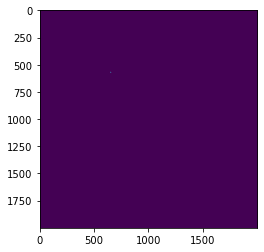

In [163]:
plt.imshow(test_DB==test_db)

In [164]:
mask = test_DB==test_db

In [165]:
np.count_nonzero(mask).compute()

29

In [166]:
masked_skeleton = skimage.morphology.skeletonize(np.int_(np.multiply(mask,test_SO>1)))

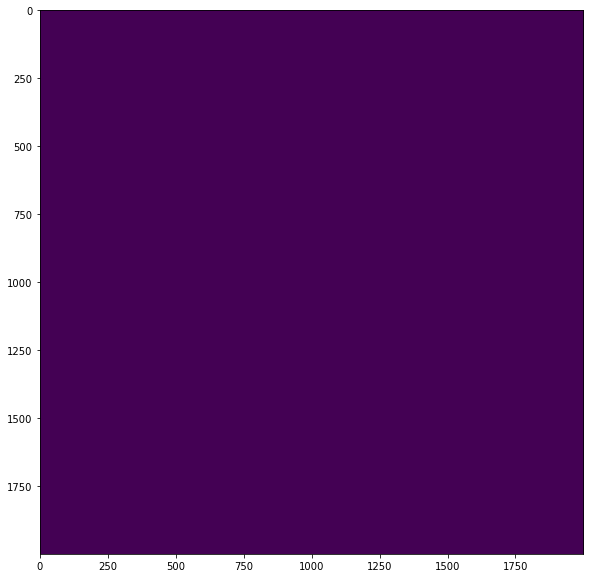

In [167]:
plt.figure(figsize=(10,10))
plt.imshow(masked_skeleton)


In [168]:
p = np.zeros((int(180/10),1))
for angle in np.arange(0,180,10):
    p[int(angle/10)] = skimage.measure.perimeter_crofton(skimage.transform.rotate(masked_skeleton,angle),4)*32

0.0

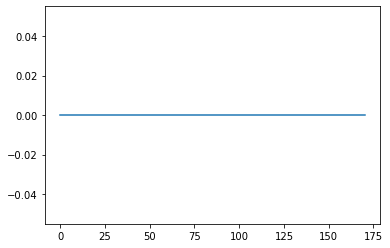

In [169]:
plt.plot(np.arange(0,180,10),p)
np.mean(p)

In [170]:
np.mean(p)/(np.count_nonzero(mask)*32**2).compute()

0.0

In [181]:
def total_drainage_distance(regionmask,intensityimage):
    area = np.count_nonzero(regionmask)
    if area>100:
        masked_image = np.multiply((intensityimage>1),regionmask)
        skeleton = skimage.morphology.skeletonize(np.int_(masked_image))
        p = np.zeros((6,1))
        for angle in np.arange(0,180,30):
            rotated = skimage.transform.rotate(skeleton,angle)
            p[int(angle/30)] = (skimage.measure.perimeter_crofton(skimage.transform.rotate(skeleton,angle), 4)/2)
        return np.mean(p) * cellsize
    else:
        return area*0.01*cellsize**2
def mean_distance_to_main_stream(regionmask,intensityimage):
    max_so = np.max(intensityimage)
    distance_image = scipy.ndimage.distance_transform_bf(np.bitwise_not(np.multiply(intensityimage,regionmask)==max_so))
    distance_image_clipped = distance_image[regionmask]
    return np.mean(distance_image_clipped)* cellsize    
    

In [182]:
def DB_regionprops5(DB,StreamOrder):
    table_prop = skimage.measure.regionprops_table(DB,StreamOrder,properties = ('label','mean_intensity', 'max_intensity','area'),extra_properties=(total_drainage_distance,mean_distance_to_main_stream))
    #pd_prop = pd.DataFrame(table_prop,index=table_prop['label'])
    #pd.concat([b,pd_prop])?
    return table_prop

In [185]:
#cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.5213c8ccf4b04c0cb192ac59752d6d2e, status=RUNNING>,
 ClusterReport<name=prod.219c40b167c94ed4a7e5059ede11de30, status=RUNNING>]

In [184]:
gateway.stop_cluster(gateway.list_clusters()[0])

In [175]:
cluster.scale(10)

In [186]:
x1,x2,y1,y2 = chunks[12]

test_prop = dask.array.map_blocks(lambda DB,StreamOrder: DB_regionprops5(DB,StreamOrder),DB_label.data[x1:x2,y1:y2],accumulation.Streams_order.chunk(2000).data[x1:x2,y1:y2], dtype=dict)
test_prop = test_prop.compute()
pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'mean_SO': test_prop['mean_intensity'],'max_SO': test_prop['max_intensity'],'total_drainage_distance': test_prop['total_drainage_distance'],'mean_distance_to_main_stream': test_prop['mean_distance_to_main_stream'], 'area':test_prop['area']},index=test_prop['label'])
DB_prop6 = DB_prop6.append(pd_prop, ignore_index=True)

In [187]:
DB_prop6 = DB_prop6.assign(drainage_density = lambda x: x['total_drainage_distance']/(x['area']*32**2))

<AxesSubplot:>

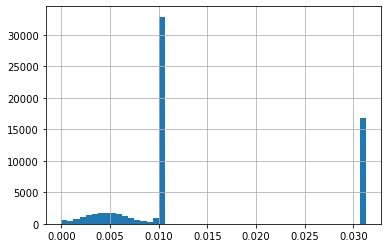

In [188]:
DB_prop6.drainage_density.hist(bins=50)

In [189]:
b_dict = {'label','mean_SO','max_SO','total_drainage_distance','mean_distance_to_main_stream'}
label=[0]
DB_prop6 = pd.DataFrame(data={},index = label,columns=b_dict)
for x1,x2,y1,y2 in chunks.values():
    test_prop = dask.array.map_blocks(lambda DB,StreamOrder: DB_regionprops5(DB,StreamOrder),DB_label.data[x1:x2,y1:y2],accumulation.Streams_order.chunk(2000).data[x1:x2,y1:y2], dtype=dict)
    test_prop = test_prop.compute()
    pd_prop = pd.DataFrame(data = {'label': test_prop['label'],'mean_SO': test_prop['mean_intensity'],'max_SO': test_prop['max_intensity'],'total_drainage_distance': test_prop['total_drainage_distance'],'mean_distance_to_main_stream': test_prop['mean_distance_to_main_stream']},index=test_prop['label'])
    DB_prop6 = DB_prop6.append(pd_prop, ignore_index=True)

In [190]:
DB_prop6 = DB_prop6.groupby('label').agg({'mean_SO':'mean',
                             'max_SO':'max',#check later
                             'total_drainage_distance':'sum',
                             'mean_distance_to_main_stream':'mean'}).reset_index()

In [191]:
DB_prop6.to_csv('Amery_32m_DBprop6.csv')

In [192]:
DB_prop6 = pd.read_csv('Amery_32m_DBprop6.csv')

In [193]:
DB_merged_prop = DB_merged_prop.merge(DB_prop6)
DB_merged_prop

Dask DataFrame Structure:
                 label   area eccentricity max_depth catchment_volume  coords Area_in_m volume_to_area_ratio coords_reformatted Unnamed: 0  mean_SO max_SO total_drainage_distance mean_distance_to_main_stream drainage_density
npartitions=100                                                                                                                                                                                                                 
                 int64  int64      float64     int64          float64  object   float64              float64             object      int64  float64  int64                 float64                      float64          float64
                   ...    ...          ...       ...              ...     ...       ...                  ...                ...        ...      ...    ...                     ...                          ...              ...
...                ...    ...          ...       ...              ...     ...       ...                  ...                ...        ...      ...    ...                     ...                          ...              ...
                   ...    ...          ...       ...              ...     ...       ...                  ...                ...        ...      ...    ...                     ...                          ...              ...
                   ...    ...          ...       ...              ...     ...       ...                  ...                ...        ...      ...    ...                     ...                          ...              ...
Dask Name: merge, 802 tasks

In [198]:
DB_merged_prop=DB_merged_prop.assign(drainage_density = 
                     lambda x: x['total_drainage_distance']/x['Area_in_m']*cellsize)

In [229]:
DB_merged_prop.drainage_density.head()

0    0.207466
1    0.190996
2    0.229404
3    0.245068
4    0.261750
Name: drainage_density, dtype: float64

In [230]:
DB_merged_prop.p

AttributeError: 'Series' object has no attribute 'plot'

In [ ]:
def map_DB_statistic(DB_prop_merged,stat):
    output_map = np.zeros(DB_label.shape)
    #basinnum = np.unique(DB)
    #basin_index = np.zeros(basinnum.shape)
    #for i in np.arange(1,len(basinnum)-1):
      #  basin_index[i] = DB_prop_merged[DB_prop_merged.label==basinnum[i]].index.to_list()[0]

   # basin_index = basin_index[1:]
    #DB_prop_subset = DB_prop_merged.iloc[basin_index]
    for index, row in DB_prop_merged.iterrows():
        [maskx,masky] = np.unravel_index(row.coords_reformatted[0],DB_label.shape)
        output_map[maskx,masky] = row[str(stat)]
    return output_map

In [214]:
output_map = np.zeros(DB_label.shape)
    
for index, row in DB_merged_prop.iterrows():
    [maskx,masky] = np.unravel_index(row.coords_reformatted[0],DB_label.shape)
    output_map[maskx,masky] = row['drainage_density']

KeyboardInterrupt: 

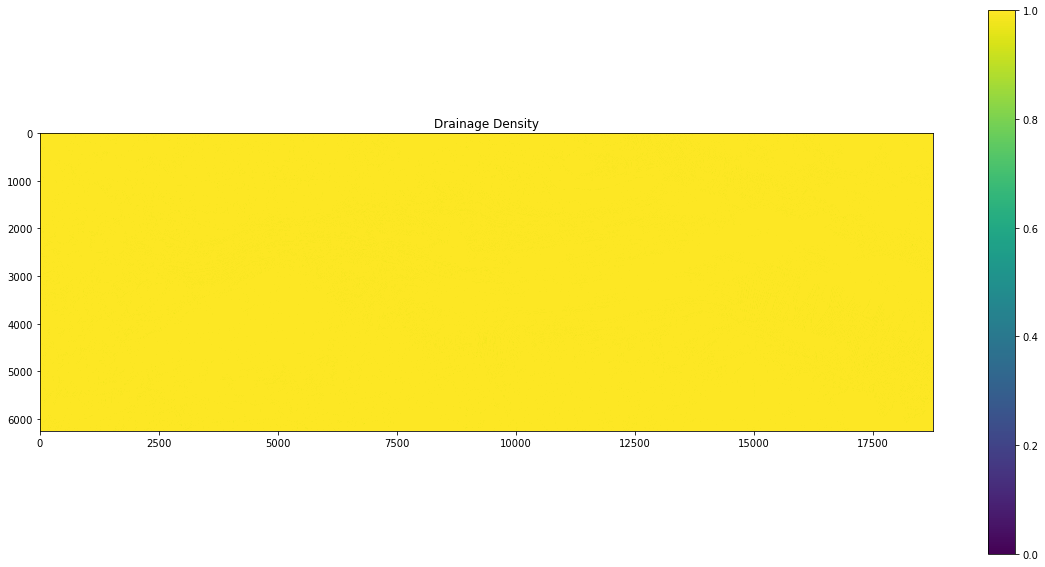

In [206]:
plt.figure(figsize=(20,10))
plt.imshow(output_map.transpose()==0)
plt.title('Drainage Density')

plt.colorbar()

(array([1.17057816e+08, 5.06000000e+02, 5.54000000e+02, 6.12000000e+02,
        7.68000000e+02, 9.14000000e+02, 1.18500000e+03, 1.53800000e+03,
        1.87300000e+03, 2.27300000e+03, 2.74200000e+03, 3.18200000e+03,
        3.74600000e+03, 4.45000000e+03, 4.98600000e+03, 5.62400000e+03,
        6.35900000e+03, 7.31500000e+03, 8.09100000e+03, 8.92900000e+03,
        9.45500000e+03, 9.90800000e+03, 9.54800000e+03, 8.37700000e+03,
        7.03900000e+03, 5.52900000e+03, 4.04800000e+03, 3.13000000e+03,
        2.23000000e+03, 1.63200000e+03, 1.07200000e+03, 7.31000000e+02,
        5.33000000e+02, 3.13000000e+02, 2.00000000e+02, 1.20000000e+02,
        7.60000000e+01, 4.80000000e+01, 2.80000000e+01, 9.00000000e+00,
        8.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([ 0.        ,  0.99594015,  1.9918803 ,  2.98782046,  3.98376061,
         4.97970076, 

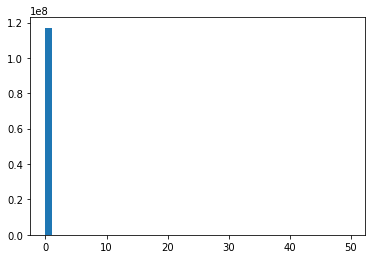

In [205]:
plt.hist(output_map.ravel(),50)

In [2]:
plt.scatter(y=DB_prop_merged.catchment_volume[DB_prop_merged.mean_velocity>-100], x= DB_prop_merged.mean_velocity[DB_prop_merged.mean_velocity>-100])
plt.xlabel('Mean velocity (m/year)')
plt.ylabel('Catchment Volume (m^3)')

NameError: name 'plt' is not defined

Text(0, 0.5, 'Frequency')

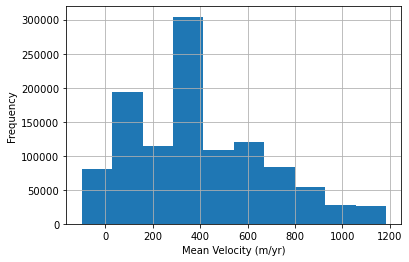

In [98]:
DB_prop_merged.mean_velocity[DB_prop_merged.mean_velocity>-100].hist()
plt.xlabel('Mean Velocity (m/yr)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Catchment Volume (m^3)')

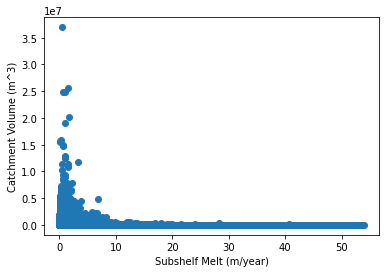

In [85]:
plt.scatter(DB_prop_merged.subshelfmelt.where(DB_prop_merged.subshelfmelt>0),DB_prop_merged.catchment_volume.where(DB_prop_merged.subshelfmelt>0))
                                                                            
plt.xlabel('Subshelf Melt (m/year)')
            
plt.ylabel('Catchment Volume (m^3)')

(0.0, 5000000.0)

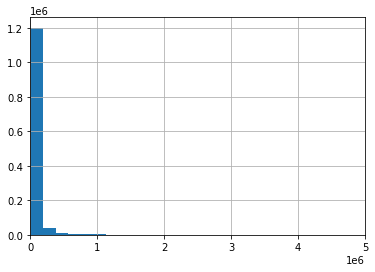

In [109]:
DB_prop_merged.Area_in_m[DB_prop_merged.Area_in_m>5000].hist(bins=1000)
plt.xlim(0, 5e6)

In [119]:
DB_prop_merged = DB_prop_merged.merge(DB_prop5)


In [120]:
DB_prop_merged

Unnamed: 0  Unnamed: 0.1    label  area  eccentricity  max_intensity  \
0                 0             0        1    41      0.791183              0   
1                 1             1        2   203      0.972609              0   
2                 2             2        3    21      0.822158              0   
3                 3             3        4    27      0.895215              0   
4                 4             4        5    14      0.895732              0   
...             ...           ...      ...   ...           ...            ...   
1117117     1284248       1284248  1272472    10      0.969048              0   
1117118     1284250       1284250  1272474     8      0.894427              0   
1117119     1284251       1284251  1272475     9      0.694588              0   
1117120     1284253       1284253  1272477    15      0.968744              0   
1117121     1284256       1284256  1272480   126      0.972442              0   

         catchment_volume  Area_in_m    index  filled_DB  mean_velocity  \
0                0.000000    41984.0  1150962          1   -9999.000000   
1              413.951981   207872.0  1271957          5   -9999.000000   
2                0.000000    21504.0  1271958          2   -9999.000000   
3                0.000000    27648.0  1271959          3   -9999.000000   
4                0.000000    14336.0  1271960          4   -9999.000000   
...                   ...        ...      ...        ...            ...   
1117117         82.293777    10240.0    37412       4817       0.295617   
1117118         30.604263     8192.0   131405       4806       0.416356   
1117119         42.494702     9216.0   131406       6292       0.283768   
1117120         16.768218    15360.0    68646       4474       0.429302   
1117121       2755.825857   129024.0     6640       4474       0.435717   

         subshelfmelt  vulnerability  
0                 NaN            NaN  
1                 NaN            NaN  
2                 NaN            NaN  
3                 NaN            NaN  
4                 NaN            NaN  
...               ...            ...  
1117117           NaN            NaN  
1117118           NaN            NaN  
1117119           NaN            NaN  
1117120           NaN            NaN  
1117121           NaN            NaN  

[1117122 rows x 13 columns]

# TO DO:
1. Ice Shelf Vulnerability Map
2. drainage network

In [77]:
DB_prop_merged.mean_velocity.min()


-9999.0

In [ ]:
#Build  data structure  on each drainage Catchments

b_dict = {'CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h','p'}
b = pd.DataFrame(data={},columns=b_dict)

histcount = np.bincount(dDB.ravel())
catchment_num = np.max(DB.ravel())
valid_catchment= []
for kk in np.arange(0,catchment_num):
    CatchmentNumber = kk;
    Mask = DB == kk; 
    CatchmentArea = (np.sum(np.int_(np.ravel(Mask)))*cellsize); # basin area in m^2
    if CatchmentArea>0:
        valid_catchment = np.append(valid_catchment,kk)


for catchment in valid_catchment:
    CatchmentNumber = catchment;
    Mask = DB == catchment; 
    CatchmentArea = (np.sum(np.int_(np.ravel(Mask))*cellsize)); # basin area in m^2
    MaskLogical = Mask;
    MaskXY = np.where(Mask);  # mask for the basin
    MaskI= np.ravel_multi_index(MaskXY,dem.shape)
    depths = P_all[MaskXY] #Water accomodation space in drainage basin
    if np.count_nonzero(depths>0)<4: #If accomodation space is zero, i.e, no nonzero depths
        skip = 1;
        h = 0;
        maxdepth = 0;
        Volume = 0;
        hw = np.zeros(depths.size)
        continue
    else:
        valid = np.argwhere(depths>=0)
        depths = depths[valid];
        heights = np.max(depths) - depths; #potential water height from bottom
        skip = 0;        
        Volume = (np.sum(depths.ravel())*cellsize);
        heights_sorted = np.sort(list(heights.flatten()));
        while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
            I = np.argwhere(np.diff(heights_sorted)==0);
            heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
        hw = heights_sorted;   # heights for hypsometry
        maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
        h = 0;   # initial water depth is demero
        volume = np.zeros((len(heights)-1,1));
        if np.count_nonzero(depths)>5:
            totalVolume = Volume;
            for i in np.arange(0,len(heights)-1):
                volume[i] = (volume[i-1]+ (hw[i+1]-hw[i])*(i*cellsize));

            Y = (np.log(volume/totalVolume));
            X  = list(np.log(hw[0:-1]/maxdepth)),
            X = X[0]
            X.pop(0)
            Y = list(Y.flatten())
            Y.pop(0)
            reg = np.polyfit(list(X),list(Y),1)

            p = reg[0];
        else:
            p = 1;
    data={'CatchmentNumber':CatchmentNumber,
           'CatchmentArea':CatchmentArea,
           'MaskLogical':MaskLogical.ravel(),
           'MaskI':MaskI,
            'MaskXY': MaskXY,
           'skip':skip,
           'Volume':Volume,
           'maxdepth':maxdepth,
           'hw':hw,
           'h':h,
           'p':p
            }
    DrainageBasin = pd.Series(data)
    b = b.append(DrainageBasin, ignore_index=True)